In [1]:
import numpy as np
import xarray as xr
from odbind.survey import Survey
from odbind.seismic3d import Seismic3D

## Read a cube of data using ODBind

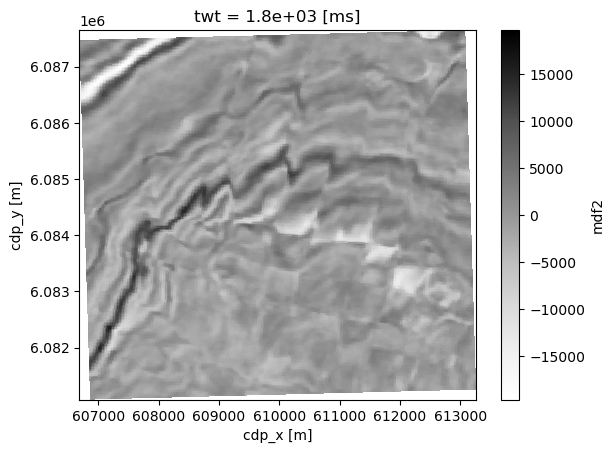

In [2]:
f3demo = Survey('F3_Demo_2020')
vol = Seismic3D(f3demo, '4 Dip steered median filter')
subvol = vol.as_xarray(*vol.volume[400:655,350:605,205:460])
xr.plot.pcolormesh(subvol['mdf2'][:,:,245], x='cdp_x', y='cdp_y', cmap='Greys')

## Load the FaultNet Torch model

In [3]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.jit.load('network/FaultNet_Gamma0.7.pt').to(device)

## Apply the FaultNet Torch model and display a z slice of the result

In [4]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

input_tensor = normalization(subvol['mdf2'].data.transpose(2,0,1))
input_tensor = torch.from_numpy(input_tensor)[None, None, :, :, :].to(device)
with torch.no_grad():
        torch_result = model(input_tensor).cpu().numpy()[0, 0, :, :, :]

subvol['FaultNet'] = (subvol.dims, torch_result.transpose(1,2,0))

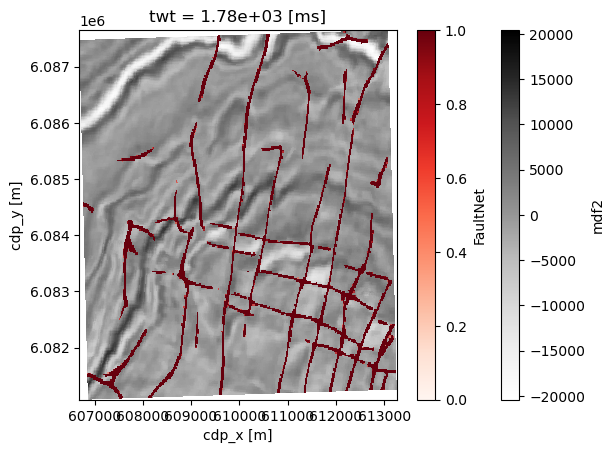

In [5]:
alphas = subvol['FaultNet'][:,:,240]
alphas = np.where(alphas <0.5, 0, alphas)
xr.plot.pcolormesh(subvol['mdf2'][:,:,240], x='cdp_x', y='cdp_y', cmap='Greys')
xr.plot.pcolormesh(subvol['FaultNet'][:,:,240], x='cdp_x', y='cdp_y', alpha=alphas, cmap='Reds')

## Export the FaultNet model to ONNX format

In [6]:
import torch.onnx
torch.onnx.export(  model, 
                    input_tensor, 
                    'network/faultnet_0.7.onnx', 
                    opset_version=17, 
                    export_params=True,
                    input_names=['faultnet_in'], 
                    output_names=['faultnet_out'],
                    dynamic_axes={  'faultnet_in' : {0 : 'batch_size'},
                                    'faultnet_out' : {0 : 'batch_size'}})

/opt/seismic/ODTPython/Python_1.4.4/envs/odmlpython-cuda113/lib/python3.10/site-packages/torch/onnx/utils.py:825: UserWarning: no signature found for <torch.ScriptMethod object at 0x7f6712b509f0>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")


============ Diagnostic Run torch.onnx.export version 2.0.0.post200 ============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Test the FaultNet ONNX model

In [7]:
import onnxruntime
ort_session = onnxruntime.InferenceSession("network/faultnet_0.7.onnx")

input = np.expand_dims(normalization(subvol['mdf2'].data.transpose(2,0,1)),(0,1))
ort_inputs = {ort_session.get_inputs()[0].name: input}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(torch_result, ort_outs[0][0,0,:,:,:], rtol=1e-02, atol=1e-02)

## Add input and output transpose operations to adapt model to OpendTect IO

The FaultNet PyTorch model expects data in (z, inline, crossline) order. OpendTect sends data in (inline, crossline, z) order. Consequently the ONNX model generated from the PyTorch FaultNet model needs to include pre and post processing steps to transpose the input and output.  

In [8]:
import onnx

def make_preprocess_model(model_save_name: str, model_input_name: str, model_output_name: str):
    inp = onnx.helper.make_tensor_value_info(
            model_input_name,
            onnx.TensorProto.FLOAT,
            [None, 1, 256, 256, 256])

    out = onnx.helper.make_tensor_value_info(
            model_output_name,
            onnx.TensorProto.FLOAT,
            [None, 1, 256, 256, 256])

    pre_transpose_node = onnx.helper.make_node("Transpose", inputs=[model_input_name], outputs=[model_output_name], perm=[0,1,4,2,3])
    graph = onnx.helper.make_graph([pre_transpose_node], "preprocess", [inp], [out])
    model = onnx.helper.make_model(graph)
    model.opset_import[0].version = 17
    model.ir_version = 8
    model = onnx.shape_inference.infer_shapes(model)
    onnx.checker.check_model(model)
    onnx.save(model, model_save_name)

def make_postprocess_model(model_save_name: str, model_input_name: str, model_output_name: str):
    inp = onnx.helper.make_tensor_value_info(
            model_input_name,
            onnx.TensorProto.FLOAT,
            [None, 1, 256, 256, 256])

    out = onnx.helper.make_tensor_value_info(
            model_output_name,
            onnx.TensorProto.FLOAT,
            [None, 1, 256, 256, 256])

    post_transpose_node = onnx.helper.make_node("Transpose", inputs=[model_input_name], outputs=[model_output_name], perm=[0,1,3,4,2])
    graph = onnx.helper.make_graph([post_transpose_node], "postprocess", [inp], [out])
    model = onnx.helper.make_model(graph)
    model.opset_import[0].version = 17
    model.ir_version = 8
    model = onnx.shape_inference.infer_shapes(model)
    onnx.checker.check_model(model)
    onnx.save(model, model_save_name)

make_preprocess_model('network/preprocess.onnx', 'seismic', 'prepro_out')
make_postprocess_model('network/postprocess.onnx', 'postpro_in', 'faults')

model1 = onnx.load('network/preprocess.onnx')
model2 = onnx.load('network/faultnet_0.7.onnx')
model3 = onnx.load ('network/postprocess.onnx')

model1_2 = onnx.compose.merge_models(
            model1, model2,
            io_map=[('prepro_out', 'faultnet_in')],
            outputs=['faultnet_out']
)
model1_2_3 = onnx.compose.merge_models(
                model1_2, model3,
                io_map=[('faultnet_out', 'postpro_in')],
                outputs=['faults']
)

onnx.save(model1_2_3, 'network/prepro_faultnet_0.7.onnx')

## Test FaultNet ONNX model that includes pre-post data transpose

In [9]:
import onnxruntime
ort_session = onnxruntime.InferenceSession("network/prepro_faultnet_0.7.onnx")

input = np.expand_dims(normalization(subvol['mdf2'].data), (0,1))
ort_inputs = {ort_session.get_inputs()[0].name: input}
ort_outs_aug = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(torch_result.transpose(1,2,0), ort_outs_aug[0][0,0,:,:,:], rtol=1e-02, atol=1e-02)


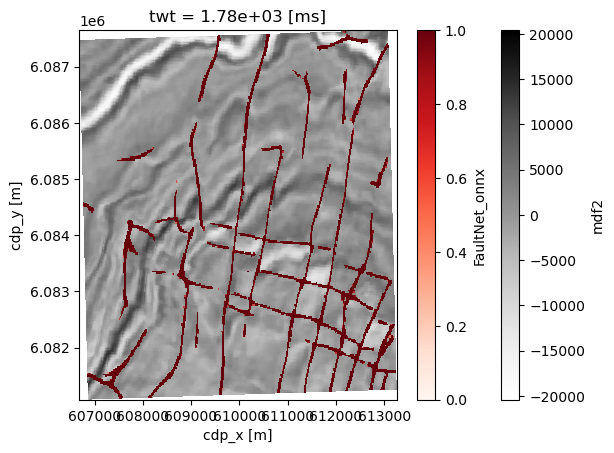

In [10]:
subvol['FaultNet_onnx'] = (subvol.dims, ort_outs_aug[0][0,0,:,:,:])
alphas = subvol['FaultNet_onnx'][:,:,240]
alphas = np.where(alphas <0.5, 0, alphas)
xr.plot.pcolormesh(subvol['mdf2'][:,:,240], x='cdp_x', y='cdp_y', cmap='Greys')
xr.plot.pcolormesh(subvol['FaultNet_onnx'][:,:,240], x='cdp_x', y='cdp_y', alpha=alphas, cmap='Reds')